# Proyecto Bimestral: Sistema de Recuperaci´on de Información basado en Reuters-21578
## 1. Introducción
El objetivo de este proyecto es diseñar, construir, programar y desplegar un Sistema de Recuperación de Información (SRI) utilizando el corpus Reuters-21578.
## 2. Fases del Proyecto
###  2.1. Adquisición de datos

*   Descargar el Corpus Reuters-21578
*   Descomprimir y organizar los archivos
*   Documentar el proceso de adquisición de datos

![Descripción de la imagen](images/corpus_reuters.jpg)

#### Descarga y análisis inicial del corpus

1. El archivo comprimido fue descargado y descomprimido en una carpeta local vinculada a un repositorio de GitHub.
2. Posteriormente, se analizó el contenido del corpus, obteniendo los siguientes resultados:
   - **Carpeta `test`**: Contiene 3019 archivos.
   - **Carpeta `training`**: Contiene 7769 archivos.
   - **Archivo `cats`**: Incluye las categorías.
   - **Archivo `readme`**: Proporciona información general sobre el corpus.
   - **Archivo `stopwords`**: Contiene una lista de palabras vacías.

#### Librerias y Dependencias necesarias

#### Notas

Al no encontrarnos en un entorno de Google Colab, sino en VS, nos basta con ejecutar una sola vez el comando `!pip install rarfile` para tener la biblioteca `rarfile` en nuestro entorno.

In [27]:
#!pip install rarfile

Al no encontrarnos en un entorno de Google Colab, sino en VS, nos basta con ejecutar una sola vez el comando `!pip install nltk` para tener la biblioteca `nltk` en nuestro entorno.

In [29]:
#!pip install nltk

El comando `pip install scikit-learn` instala la librería `scikit-learn`, que es una herramienta para realizar tareas de aprendizaje automático (machine learning) como clasificación, regresión y clustering.

In [17]:
#pip install scikit-learn

El comando `pip install gensim` instala la librería `gensim`, que se utiliza para el procesamiento de texto y la creación de modelos de aprendizaje automático, como Word2Vec, para generar representaciones vectoriales de palabras.

In [19]:
#pip install gensim

In [1]:
# Librerias necesarias
import os
import re
import nltk
import rarfile
import time # Evaluar tecnicas de vectorización
import psutil # Evaluar tecnicas de vectorización
import gc # Evaluar tecnicas de vectorización
import numpy as np
import pandas as pd # Obtener tablas
import matplotlib.pyplot as plt # Para obtener gráfica
import seaborn as sns # Para obtener gráfica
from collections import defaultdict # Para el indice invertido
from nltk.tokenize import word_tokenize # para tokenizar
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Matriz TD, Matriz TF-IDF
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

### 2.2. Preprocesamiento

#### 2.2.1. Extraer el contenido relevante de los documentos

In [2]:
rarfile.UNRAR_TOOL = r"D:\UnRAR\UnRAR.exe" # Cambiar por ubicación local de tu herramienta UNRAR

# Ruta del archivo .rar
rar_path = 'material/reuters.rar'
output_dir = 'material/content'

# Crear el directorio de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Descomprimir el archivo .rar
with rarfile.RarFile(rar_path) as rf:
    rf.extractall(output_dir)

# Verificar que se haya descomprimido correctamente
print("Archivos extraídos:")
print(os.listdir(output_dir))

Archivos extraídos:
['reuters']


In [3]:
# Directorios de documentos
train_dir = 'material/content/reuters/training'
test_dir = 'material/content/reuters/test'
cats_file = 'material/content/reuters/cats.txt'

# Función para extraer contenido de un archivo de noticias
def extraer_texto(filepath):
    try:
        with open(filepath, 'r', encoding='latin-1') as file:
            contenido = file.read()
            texto_limpio = contenido.strip()  # Elimina espacios en blanco iniciales y finales
            return texto_limpio
    except Exception as e:
        print(f"Error al leer el archivo {filepath}: {e}")
        return ""

# Función para cargar las categorías de los documentos
def cargar_categorias(filepath):
    categorias = {}
    try:
        with open(filepath, 'r', encoding='latin-1') as file:
            for linea in file:
                partes = linea.strip().split()  # Divide la línea en partes separadas por espacios
                if len(partes) >= 2:
                    doc_id = partes[0]  # Primer elemento es el id del documento (test/14826, training/1)
                    etiquetas = partes[1:]  # Resto de elementos son categorías
                    categorias[doc_id] = etiquetas
    except Exception as e:
        print(f"Error al leer el archivo de categorías {filepath}: {e}")
    return categorias

# Función para cargar los documentos y asociar categorías
def cargar_documentos(directorio, tipo, categorias_dict):
    data = []
    archivos = os.listdir(directorio)
    if not archivos:
        print(f"No se encontraron archivos en {directorio}")
    for archivo in archivos:
        filepath = os.path.join(directorio, archivo)
        doc_id = f"{tipo}/{archivo}"
        texto = extraer_texto(filepath)
        categorias = categorias_dict.get(doc_id, [])  # Obtener categorías, si no hay, devuelve lista vacía

        # Añadir a la lista para crear el dataframe
        data.append({"doc_id": doc_id, "texto": texto, "categorias": categorias})

    return data

In [4]:
# Cargar categorías
categorias_dict = cargar_categorias(cats_file)

# Listas para almacenar los datos de entrenamiento y prueba
data_train = cargar_documentos(train_dir, 'training', categorias_dict)
data_test = cargar_documentos(test_dir, 'test', categorias_dict)

# Crear dataframes
df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

# Combinar los datasets de entrenamiento y prueba en un único dataframe
df_documentos = pd.concat([df_train, df_test], ignore_index=True)

# Verificar el tamaño y algunas muestras
print(f"Total de documentos cargados: {len(df_documentos)}")
if not df_documentos.empty:
    ejemplo_doc = df_documentos.iloc[0]  # Obtener la primera fila del dataframe
    print(f"ID: {ejemplo_doc['doc_id']}")
    print(f"Texto: {ejemplo_doc['texto'][:500]}...")  # Mostrar los primeros 500 caracteres
    print(f"Categorías: {ejemplo_doc['categorias']}")
else:
    print("No se cargaron documentos.")

Total de documentos cargados: 10788
ID: training/1
Texto: BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
      The dry period means the temporao will be late this year.
      Arrivals for the week ended February 22 were 155,221 bags
  of 60 kilos making a cumulative total for the season of 5.93
  mln against 5.81 at th...
Categorías: ['cocoa']


In [5]:
# Mostrar las primeras filas del DataFrame para verificar la estructura
print(f"Columnas del dataframe: {df_documentos.columns}")  # Muestra los nombres de las columnas
print(df_documentos.head())  # Muestra las primeras 5 filas

Columnas del dataframe: Index(['doc_id', 'texto', 'categorias'], dtype='object')
           doc_id                                              texto  \
0      training/1  BAHIA COCOA REVIEW\n  Showers continued throug...   
1     training/10  COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...   
2    training/100  N.Z. TRADING BANK DEPOSIT GROWTH RISES SLIGHTL...   
3   training/1000  NATIONAL AMUSEMENTS AGAIN UPS VIACOM &lt;VIA> ...   
4  training/10000  ROGERS &lt;ROG> SEES 1ST QTR NET UP SIGNIFICAN...   

       categorias  
0         [cocoa]  
1           [acq]  
2  [money-supply]  
3           [acq]  
4          [earn]  


#### 2.2.2. Realizar limpieza de datos: eliminación de caracteres no deseados, normalización de texto, etc.

In [6]:
# Función para limpiar texto
def limpiar_texto(texto):
    # 1. Conversión a minúsculas
    texto = texto.lower()

    # 2. Eliminación de caracteres especiales y números
    texto = re.sub(r'[^a-z\s]', '', texto)

    # 3. Eliminación de espacios extra
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

In [7]:
# Aplicar la limpieza de texto a la columna 'texto' del dataframe
df_documentos['texto'] = df_documentos['texto'].apply(limpiar_texto)

# Verificar el resultado de la limpieza en un documento de ejemplo
ejemplo_doc = df_documentos.iloc[0]  # Obtener la primera fila del dataframe
print(f"ID: {ejemplo_doc['doc_id']}")
print(f"Texto limpio: {ejemplo_doc['texto'][:500]}...")

ID: training/1
Texto limpio: bahia cocoa review showers continued throughout the week in the bahia cocoa zone alleviating the drought since early january and improving prospects for the coming temporao although normal humidity levels have not been restored comissaria smith said in its weekly review the dry period means the temporao will be late this year arrivals for the week ended february were bags of kilos making a cumulative total for the season of mln against at the same stage last year again it seems that cocoa delive...


#### 2.2.3. Tokenización: dividir el texto en palabras o tokens

#### Nota
Al no encontrarnos en un entorno de Google Colab, sino en VS, nos basta con ejecutar una sola vez el comando `nltk.download('punkt')` o `nltk.download('punkt_tab')`, por lo cual no es necesario volver a ejcutarlo.

In [6]:
# Descargar los recursos necesarios de NLTK para tokenizar texto en oraciones y palabras
#nltk.download('punkt')
#nltk.download('punkt_tab')

In [8]:
# Función para tokenizar texto
def tokenizar_texto(texto):
    # Utilizamos word_tokenize de NLTK para dividir en tokens
    tokens = word_tokenize(texto)
    return tokens

In [9]:
# Aplicar la tokenización a la columna 'texto' del dataframe
df_documentos['tokens'] = df_documentos['texto'].apply(tokenizar_texto)

# Verificar el resultado de la tokenización en un documento de ejemplo
ejemplo_doc = df_documentos.iloc[0]  # Obtener la primera fila del dataframe
print(f"ID: {ejemplo_doc['doc_id']}")
print(f"Tokens: {ejemplo_doc['tokens'][:20]}...")

ID: training/1
Tokens: ['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'the', 'week', 'in', 'the', 'bahia', 'cocoa', 'zone', 'alleviating', 'the', 'drought', 'since', 'early', 'january', 'and']...


#### 2.2.4. Eliminar stop words y  aplicar stemming o lematización.

In [10]:
# Cargar el archivo de stopwords proporcionado
ruta_stopwords = 'material/content/reuters/stopwords'
stopwords_personalizadas = set()

with open(ruta_stopwords, 'r') as archivo:
    for linea in archivo:
        palabra = linea.strip()  # Removemos espacios y saltos de línea
        if palabra:  # Evitamos añadir líneas vacías
            stopwords_personalizadas.add(palabra.lower())

# Verificamos algunas stop words cargadas
print("Ejemplo de Stop Words cargadas:", list(stopwords_personalizadas)[:15])

Ejemplo de Stop Words cargadas: ["here's", "that's", 'plus', "couldn't", 'since', "what's", 'hereafter', 'next', 'only', 'and', 'into', 'unlikely', 'been', "wasn't", "isn't"]


In [11]:
# Función para eliminar stop words de los tokens
def eliminar_stopwords(tokens, stopwords):
    # Filtramos los tokens que no están en la lista de stopwords
    tokens_filtrados = [token for token in tokens if token.lower() not in stopwords]
    return tokens_filtrados

# Aplicamos la eliminación de stopwords a la columna 'tokens' del dataframe
df_documentos['tokens'] = df_documentos['tokens'].apply(lambda x: eliminar_stopwords(x, stopwords_personalizadas))

# Verificar el resultado después de eliminar stop words en un documento de ejemplo
ejemplo_doc = df_documentos.iloc[0]  # Obtener la primera fila del dataframe
print(f"ID: {ejemplo_doc['doc_id']}")
print(f"Tokens sin Stop Words: {ejemplo_doc['tokens'][:20]}...")

ID: training/1
Tokens sin Stop Words: ['bahia', 'cocoa', 'review', 'showers', 'continued', 'week', 'bahia', 'cocoa', 'zone', 'alleviating', 'drought', 'early', 'january', 'improving', 'prospects', 'coming', 'temporao', 'normal', 'humidity', 'levels']...


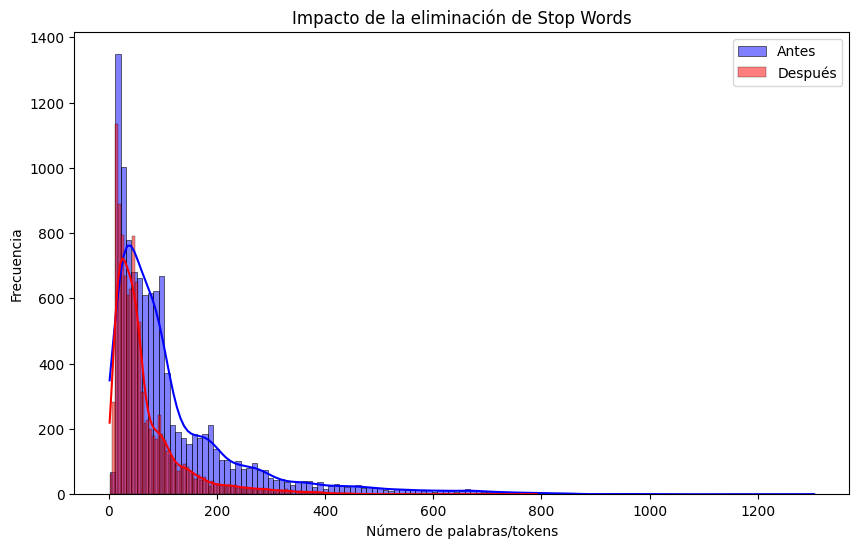

In [12]:
longitud_antes = df_documentos['texto'].apply(lambda x: len(x.split()))
longitud_despues = df_documentos['tokens'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(longitud_antes, color='blue', label='Antes', kde=True)
sns.histplot(longitud_despues, color='red', label='Después', kde=True)
plt.legend()
plt.title("Impacto de la eliminación de Stop Words")
plt.xlabel("Número de palabras/tokens")
plt.ylabel("Frecuencia")
plt.show()

#### Nota
Para nuestro caso de estudio y aplicación de este proyecto, aplicaremos **Steming**. 

Como equipo, consideramos más eficiente en términos de recursos porque el stemming utiliza reglas más simples y rápidas para reducir las palabras a su raíz, mientras que la lemmatización requiere un procesamiento más complejo y el uso de diccionarios para obtener la forma base correcta de las palabras.

In [13]:
# Inicializar el stemmer
stemmer = PorterStemmer()

# Función para aplicar stemming a los tokens de un documento
def aplicar_stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

In [14]:
# Aplicar el stemming a la columna 'tokens' del dataframe
df_documentos['tokens'] = df_documentos['tokens'].apply(aplicar_stemming)

# Verificar un documento de ejemplo después del stemming
ejemplo_doc = df_documentos.iloc[0]  # Obtener la primera fila del dataframe
print(f"ID: {ejemplo_doc['doc_id']}")
print(f"Tokens con Stemming: {ejemplo_doc['tokens'][:20]}...")

ID: training/1
Tokens con Stemming: ['bahia', 'cocoa', 'review', 'shower', 'continu', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'normal', 'humid', 'level']...


### 2.3.  Representación de Datos en Espacio Vectorial

#### 2.3.1. Utilizar técnicas como Bag of Words (BoW), TF-IDF, y Word2Vec.

In [15]:
# Convertir tokens preprocesados a texto unificado para vectorización
df_documentos['texto_procesado'] = df_documentos['tokens'].apply(lambda x: ' '.join(x))

# Inicializar el vectorizador BoW
bow_vectorizer = CountVectorizer()

# Aplicar BoW a los textos procesados
bow_matrix = bow_vectorizer.fit_transform(df_documentos['texto_procesado'])

# Verificar la matriz resultante
print("Dimensiones de la matriz BoW:", bow_matrix.shape)

# Mostrar las primeras 10 palabras del vocabulario
vocabulario_bow = bow_vectorizer.get_feature_names_out()
print("Primeras 10 palabras del vocabulario BoW:", vocabulario_bow[:10])

# Inspeccionar una fila de la matriz BoW
print("Vector BoW del primer documento:")
print(bow_matrix[0].toarray())

Dimensiones de la matriz BoW: (10788, 26004)
Primeras 10 palabras del vocabulario BoW: ['aa' 'aaa' 'aabex' 'aachen' 'aaminu' 'aancor' 'aap' 'aaplu' 'aar'
 'aarnoud']
Vector BoW del primer documento:
[[0 0 0 ... 0 0 0]]


In [16]:
# Aplicar TF-IDF a los textos procesados
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_documentos['texto_procesado'])

# Verificar la matriz resultante
print("Dimensiones de la matriz TF-IDF:", tfidf_matrix.shape)

# Mostrar las primeras 10 palabras del vocabulario
vocabulario_tfidf = tfidf_vectorizer.get_feature_names_out()
print("Primeras 10 palabras del vocabulario TF-IDF:", vocabulario_tfidf[:10])

# Inspeccionar una fila de la matriz TF-IDF
print("Vector TF-IDF del primer documento:")
print(tfidf_matrix[0].toarray())

Dimensiones de la matriz TF-IDF: (10788, 26004)
Primeras 10 palabras del vocabulario TF-IDF: ['aa' 'aaa' 'aabex' 'aachen' 'aaminu' 'aancor' 'aap' 'aaplu' 'aar'
 'aarnoud']
Vector TF-IDF del primer documento:
[[0. 0. 0. ... 0. 0. 0.]]


In [17]:
# Crear el modelo Word2Vec
model_w2v = Word2Vec(sentences=df_documentos['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Función para obtener el vector promedio de un documento
def obtener_vector_promedio(tokens, model):
    # Inicializamos un vector de ceros
    vector_promedio = np.zeros(model.vector_size)
    count = 0
    for token in tokens:
        if token in model.wv:
            vector_promedio += model.wv[token]
            count += 1
    if count > 0:
        vector_promedio /= count  # Promediamos si hay tokens en el modelo
    return vector_promedio

# Obtener los vectores promedio para todos los documentos
documentos_w2v = []
for tokens in df_documentos['tokens']:
    vector = obtener_vector_promedio(tokens, model_w2v)
    documentos_w2v.append(vector)

# Convertimos la lista a una matriz
documentos_w2v_matrix = np.array(documentos_w2v)

# Verificar el resultado
print("Dimensiones de la matriz Word2Vec:", documentos_w2v_matrix.shape)

# Inspeccionar el primer vector de documento
print("Vector Word2Vec del primer documento:")
print(documentos_w2v_matrix[0])

Dimensiones de la matriz Word2Vec: (10788, 100)
Vector Word2Vec del primer documento:
[-0.05878227  0.08579733  0.11234514  0.38796105  0.48657682 -0.65289579
  0.48897037  0.4974072  -0.50661919 -0.41306566 -0.30527269 -0.97482067
 -0.07369181  0.46987091 -0.136568   -0.2997364   0.53975214  0.12987185
 -0.08723782 -0.52544498  0.43572241  0.1988409   0.18854701 -0.48793184
  0.33506815  0.43010931 -0.36393281  0.0946827  -0.59619241 -0.16041969
  0.8216278   0.11857633  0.22268001 -0.41891468 -0.11633017  0.35965586
  0.02016389 -0.383889   -0.33308436 -0.53015827  0.32657262 -0.38429476
 -0.4531377  -0.5053037   0.32973918  0.13203401  0.11231756  0.00225087
  0.14970366  0.02810604  0.416181   -0.27689025 -0.38544975  0.51563478
 -0.58870518  0.48628595  0.00154705 -0.08918639 -0.38473984 -0.01855412
  0.03355802  0.02144246  0.18707961  0.16033028 -0.41560639  0.57329652
 -0.03236341  0.27634464 -0.6362472   0.79992417 -0.3769906   0.25549519
  0.42056988  0.06529345  0.53179708 -

#### 2.3.2. Evaluar las diferentes técnicas de vectorización.

In [18]:
# Función para medir el tiempo y la memoria
def medir_tiempo_memoria(func):
    # Medir el tiempo de ejecución
    start_time = time.time()
    
    # Medir la memoria antes de ejecutar
    proceso = psutil.Process()
    memoria_inicial = proceso.memory_info().rss  # Memoria en bytes
    
    # Ejecutar la función
    result = func()
    
    # Medir el tiempo y la memoria después de ejecutar
    end_time = time.time()
    memoria_final = proceso.memory_info().rss
    memoria_utilizada = memoria_final - memoria_inicial
    
    # Calcular tiempo de ejecución
    tiempo_ejecucion = end_time - start_time
    
    return tiempo_ejecucion, memoria_utilizada, result

# Evaluar BoW (Bag of Words)
def evaluar_bow():
    vectorizer = CountVectorizer()
    X_bow = vectorizer.fit_transform(df_documentos)
    return X_bow

# Evaluar TF-IDF
def evaluar_tfidf():
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(df_documentos)
    return X_tfidf

# Evaluar word2vec
def evaluar_word2vec():
    model_w2v = Word2Vec(sentences=[tokens for tokens in df_documentos['tokens']], vector_size=100, window=5, min_count=1, workers=4)

    # Función para obtener el vector promedio de los tokens
    def obtener_vector_promedio(tokens, model):
        vectores = [model.wv[token] for token in tokens if token in model.wv]
        if vectores:
            return np.mean(vectores, axis=0)
        else:
            return np.zeros(model.vector_size)
    
    # Obtener el vector promedio para cada documento
    documentos_w2v = {index: obtener_vector_promedio(tokens, model_w2v) for index, tokens in df_documentos['tokens'].items()}
    return documentos_w2v

# Evaluar cada técnica
tiempo_bow, memoria_bow, _ = medir_tiempo_memoria(evaluar_bow)
tiempo_tfidf, memoria_tfidf, _ = medir_tiempo_memoria(evaluar_tfidf)
tiempo_w2v, memoria_w2v, _ = medir_tiempo_memoria(evaluar_word2vec)

# Mostrar los resultados
print(f"Evaluación BoW: Tiempo = {tiempo_bow:.4f} segundos, Memoria = {memoria_bow / (1024 * 1024):.2f} MB")
print(f"Evaluación TF-IDF: Tiempo = {tiempo_tfidf:.4f} segundos, Memoria = {memoria_tfidf / (1024 * 1024):.2f} MB")
print(f"Evaluación Word2Vec: Tiempo = {tiempo_w2v:.4f} segundos, Memoria = {memoria_w2v / (1024 * 1024):.2f} MB")

# Limpiar memoria
gc.collect()


Evaluación BoW: Tiempo = 0.0075 segundos, Memoria = 0.00 MB
Evaluación TF-IDF: Tiempo = 0.0040 segundos, Memoria = 0.00 MB
Evaluación Word2Vec: Tiempo = 8.4891 segundos, Memoria = 7.32 MB


192

#### Conclusión de la Evaluación

- **BoW** es la técnica más rápida en términos de tiempo de ejecución y requiere una cantidad moderada de memoria para procesar los documentos. Por lo tanto, es la opción más eficiente en tiempo y memoria, ideal para aplicaciones que necesitan rapidez.
- **TF-IDF**, aunque es un poco más lento que BoW y consume algo más de memoria, ofrece un buen equilibrio entre rendimiento y precisión. Esto se debe a que calcula pesos adicionales para las palabras, lo que incrementa el tiempo de procesamiento y la memoria.
- **Word2Vec**, a pesar de usar menos memoria, tiene un tiempo de ejecución significativamente mayor. Esto se debe a que entrena un modelo de vectores de palabras, lo que es más costoso computacionalmente. Es más lento, pero resulta más robusto y preciso, especialmente cuando se necesita capturar relaciones semánticas entre las palabras.


### 2.4.  Indexación 

#### 2.4.1.  Construir un Índice invertido que mapee términos a documentos.
#### 2.4.2.  Implementar y optimizar estructuras de datos para el Índice.

In [19]:
# Función para construir el índice invertido usando TF-IDF o Word2Vec
def construir_indice_invertido_vectorizado(df_documentos, vectorizador, X_vectores, metodo="tfidf"):
    indice_invertido = defaultdict(list)  # Usamos listas para guardar las tuplas (doc_id, peso)
    
    if metodo == "tfidf":
        vocabulario = vectorizador.get_feature_names_out()  # Vocabulario de los términos
        terminos_vectores = X_vectores.toarray()  # Convertimos la matriz en un arreglo denso
    
        # Recorremos cada documento y su vector
        for doc_id, vector in zip(df_documentos['doc_id'], terminos_vectores):
            for idx, peso in enumerate(vector):
                if peso > 0:  # Solo consideramos términos con peso positivo
                    termino = vocabulario[idx]
                    indice_invertido[termino].append((doc_id, peso))
    
    elif metodo == "word2vec":
        # Asumimos que ya tenemos el modelo Word2Vec entrenado
        model_w2v = vectorizador  # El vectorizador es el modelo Word2Vec preentrenado
        # Función para obtener el vector promedio de los tokens
        def obtener_vector_promedio(tokens, model):
            vectores = [model.wv[token] for token in tokens if token in model.wv]
            if vectores:
                return np.mean(vectores, axis=0)
            else:
                return np.zeros(model.vector_size)
        
        # Recorremos cada documento y sus tokens
        for doc_id, tokens in zip(df_documentos['doc_id'], df_documentos['tokens']):
            vector_promedio = obtener_vector_promedio(tokens, model_w2v)
            for idx, valor in enumerate(vector_promedio):
                if valor > 0:  # Solo considerar componentes con valores significativos
                    # Generamos una clave ficticia para un "término" de Word2Vec
                    termino = f"word2vec_{idx}"
                    indice_invertido[termino].append((doc_id, valor))
    
    return indice_invertido

In [20]:
# Construcción del índice usando TF-IDF
indice_invertido_tfidf = construir_indice_invertido_vectorizado(
    df_documentos=df_documentos,
    vectorizador=tfidf_vectorizer,
    X_vectores=tfidf_matrix,
    metodo="tfidf"
)

# Mostrar los primeros términos del índice invertido con TF-IDF
for i, (termino, entradas) in enumerate(indice_invertido_tfidf.items()):
    if i >= 2:  # Mostrar solo el primer término
        break
    print(f"Término: '{termino}' -> Entradas: {entradas}")

Término: 'allevi' -> Entradas: [('training/1', 0.05310579931297368), ('training/10593', 0.03815671156087757), ('training/11120', 0.09196624403445228), ('training/11135', 0.07346262931907505), ('training/1611', 0.06661489457760199), ('training/2746', 0.12915292746571647), ('training/5717', 0.10108036147023328), ('training/5826', 0.1724274442826351), ('test/17502', 0.06388215198438789), ('test/17980', 0.05406388415324299), ('test/18009', 0.09674864327892421), ('test/18744', 0.05824995751946455), ('test/19165', 0.09357462346748145)]
Término: 'aprilmay' -> Entradas: [('training/1', 0.054780538020712845), ('training/10615', 0.14220330563426836), ('training/12003', 0.191931096491109), ('training/12778', 0.06161325569357757), ('training/13795', 0.20242904905657647), ('training/2246', 0.09666805921787443), ('training/2760', 0.14815063231951522), ('training/4099', 0.35757154554835224), ('training/5002', 0.18977257882078807), ('training/9362', 0.19181712487038563)]


In [21]:
indice_invertido_w2v = construir_indice_invertido_vectorizado(
    df_documentos=df_documentos,
    vectorizador=model_w2v,  # El modelo Word2Vec preentrenado
    X_vectores=None,  # No necesitamos la matriz de vectores porque usaremos tokens
    metodo="word2vec"
)

# Mostrar los primeros términos del índice invertido con Word2Vec
# for i, (termino, entradas) in enumerate(indice_invertido_w2v.items()):
#    if i >= 1:  # Mostrar solo el primer término
#        break
#    print(f"Término (Word2Vec): '{termino}' -> Entradas: {entradas}")

### Interpretación

Con el **Índice Invertido** cada línea de la salida muestra un término (como `'allevi'` o `'aprilmay'`) y los documentos (con identificadores y pesos como `('training/1', 0.05310579931297368)`) en los que dicho término aparece.

### 2.5. Diseño del Motor de Búsqueda

#### 2.5.1.  Desarrollar la lógica para procesar consultas de usuarios.

In [94]:
# Función para preprocesar la consulta del usuario
def preprocesar_consulta(consulta):
    # 1. Limpiar el texto
    texto_limpio = limpiar_texto(consulta)

    # 2. Tokenizar el texto
    tokens = tokenizar_texto(texto_limpio)

    # 3. Eliminar stopwords
    tokens_sin_stopwords = eliminar_stopwords(tokens, stopwords_personalizadas)

    # 4. Aplicar stemming (utilizando tu función definida previamente)
    tokens_finales = aplicar_stemming(tokens_sin_stopwords)

    return tokens_finales

In [95]:
# Ejemplo de consulta
consulta_usuario = "bahia cocoa review showers continued throughout week"

# Preprocesar la consulta
tokens_consulta = preprocesar_consulta(consulta_usuario)

print("Tokens procesados de la consulta:", tokens_consulta)

Tokens procesados de la consulta: ['bahia', 'cocoa', 'review', 'shower', 'continu', 'week']


In [96]:
def obtener_vector_consulta(consulta, model):
    # Preprocesamos la consulta
    tokens_consulta = preprocesar_consulta(consulta)
    return obtener_vector_promedio(tokens_consulta, model)

#### 2.5.2. Utilizar algoritmos de similitud como similitud coseno o Jaccard.

- **TF-IDF:** Utiliza la frecuencia ponderada de los términos en los documentos. Cuando usas similitud de coseno con un índice basado en TF-IDF, lo que estás comparando es qué tan similar es un documento en relación con la consulta, tomando en cuenta la frecuencia y la importancia relativa de los términos en el corpus.
- **Word2Vec (w2v):** Representa las palabras en un espacio vectorial continuo donde la similitud de coseno se usa para medir qué tan cerca están dos vectores semánticamente. Este enfoque es diferente de TF-IDF porque no considera las frecuencias de las palabras, sino que se centra en el contexto semántico y las relaciones entre palabras.

In [117]:
# Método para calcular similitud coseno usando TF-IDF
def similitud_coseno_tfidf(consulta, indice_invertido_tfidf, vectorizador_tfidf):
    # Preprocesamos la consulta
    tokens_consulta = preprocesar_consulta(consulta)
    texto_consulta = ' '.join(tokens_consulta)
    
    # Vectorizamos la consulta usando el TF-IDF
    consulta_vectorizada = vectorizador_tfidf.transform([texto_consulta])
    
    # Cálculo de similitud coseno entre la consulta y los documentos
    resultados = {}
    for termino, entradas in indice_invertido_tfidf.items():
        for doc_id, peso in entradas:
            if doc_id not in resultados:
                resultados[doc_id] = 0
            resultados[doc_id] += peso * consulta_vectorizada[0, vectorizador_tfidf.vocabulary_.get(termino, -1)]
    
    # Filtramos los resultados para que solo queden aquellos con similitud mayor a cero
    resultados_filtrados = {doc_id: similitud for doc_id, similitud in resultados.items() if similitud > 0}
    
    return resultados_filtrados

In [118]:
# Consulta de ejemplo
consulta_usuario = "cocoa"

# Similitud usando TF-IDF
resultados_tfidf = similitud_coseno_tfidf(consulta_usuario, indice_invertido_tfidf, tfidf_vectorizer)
print("Usando la similitud coseno (TF-IDF):")

# Convertimos los resultados en una lista de tuplas (doc_id, similitud) y mostramos los primeros 5
resultados_tfidf_ordenados = list(resultados_tfidf.items())[:5]

for doc_id, similitud in resultados_tfidf_ordenados:
    print(f"Doc ID: {doc_id} -> Similitud: {similitud}")

Usando la similitud coseno (TF-IDF):
Doc ID: training/1 -> Similitud: 0.28762427861670065
Doc ID: training/10403 -> Similitud: 0.318391507216608
Doc ID: test/17568 -> Similitud: 0.4153869278169666
Doc ID: test/20005 -> Similitud: 0.6549245501716716
Doc ID: training/4470 -> Similitud: 0.08633386058071144


In [120]:
def obtener_resultados_similares(consulta, model, documentos_matrix, df_documentos):
    # Vectorizamos la consulta
    consulta_vector = obtener_vector_consulta(consulta, model)
    
    if consulta_vector is None:
        return []

    # Calculamos la similitud coseno entre la consulta y todos los documentos
    similitudes = cosine_similarity([consulta_vector], documentos_matrix)

    # Recopilamos los resultados (id_documento y similitud) solo si la similitud es mayor a 0
    resultados = []
    for idx in range(len(similitudes[0])):
        similitud = similitudes[0][idx]
        if similitud > 0:  # Solo añadimos los resultados con similitud mayor a 0
            doc_id = df_documentos['doc_id'].iloc[idx]
            resultados.append((doc_id, similitud))

    return resultados

In [122]:
# Ejemplo de consulta
consulta_usuario = "cocoa"

# Realizamos la consulta
resultados_word2vec = obtener_resultados_similares(consulta_usuario, model_w2v, documentos_w2v_matrix, df_documentos)

# Filtrar resultados para que solo se muestren aquellos con similitud mayor a 0
resultados_relevantes = [(doc_id, similitud) for doc_id, similitud in resultados_word2vec if similitud > 0]

# Convertir los resultados en una lista de tuplas (doc_id, similitud) y mostrar los primeros 5 sin ordenarlos
print("Resultados usando similitud coseno (Word2Vec):")
for doc_id, similitud in resultados_relevantes[:5]:  # Mostrar solo los primeros 5 resultados
    print(f"Doc ID: {doc_id} -> Similitud: {similitud}")


Resultados usando similitud coseno (Word2Vec):
Doc ID: training/1 -> Similitud: 0.558474910479204
Doc ID: training/10 -> Similitud: 0.37071797586686517
Doc ID: training/100 -> Similitud: 0.20044728728641945
Doc ID: training/1000 -> Similitud: 0.38094223223630796
Doc ID: training/10000 -> Similitud: 0.023925359063755505


#### 2.5.2. Desarrollar un algoritmo de ranking para ordenar los resultados.

In [124]:
def ranking_tfidf(similitudes):
    # Ordenar por valor de similitud (descendente)
    return sorted(similitudes.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Ejemplo de consulta con TF-IDF
consulta_usuario = "cocoa"
resultados_tfidf = similitud_coseno_tfidf(consulta_usuario, indice_invertido_tfidf, tfidf_vectorizer)

# Aplicamos el ranking a los resultados obtenidos
resultados_tfidf_ranking = ranking_tfidf(resultados_tfidf)

# Mostrar los resultados ordenados
print("Resultados ordenados usando similitud coseno (TF-IDF):")
for doc_id, similitud in resultados_tfidf_ranking[:5]:  # Mostrar los primeros 5 resultados
    print(f"Doc ID: {doc_id} -> Similitud: {similitud}")

Resultados ordenados usando similitud coseno (TF-IDF):
Doc ID: training/10505 -> Similitud: 0.6810406780560854
Doc ID: test/20005 -> Similitud: 0.6549245501716716
Doc ID: training/5258 -> Similitud: 0.5949906381697763
Doc ID: training/10506 -> Similitud: 0.5911783156952388
Doc ID: training/10586 -> Similitud: 0.5906707742467144


In [ ]:
def ranking_w2v(similitudes):
    # Ordenar por valor de similitud (descendente)
    return sorted(similitudes, key=lambda x: x[1], reverse=True)

In [ ]:
# Ejemplo de consulta con Word2Vec
consulta_usuario = "cocoa"
resultados_word2vec = obtener_resultados_similares(consulta_usuario, model_w2v, documentos_w2v_matrix, df_documentos)

# Aplicamos el ranking a los resultados obtenidos
resultados_word2vec_ranking = ranking_w2v(resultados_word2vec)

# Mostrar los resultados ordenados
print("Resultados ordenados usando similitud coseno (Word2Vec):")
for doc_id, similitud in resultados_word2vec_ranking[:5]:  # Mostrar los primeros 5 resultados
    print(f"Doc ID: {doc_id} -> Similitud: {similitud}")

Resultados ordenados usando similitud coseno (Word2Vec):
Doc ID: training/10471 -> Similitud: 0.8969512648507765
Doc ID: training/10506 -> Similitud: 0.8951079875685393
Doc ID: training/9953 -> Similitud: 0.8910007904284262
Doc ID: test/18014 -> Similitud: 0.8824365337658062
Doc ID: training/10491 -> Similitud: 0.8789295540682431


#### Diferencias entre TF-IDF y Word2Vec

**TF-IDF:** 
- Se basa en la frecuencia de las palabras dentro de los documentos y en el corpus completo.
- Es un enfoque puramente estadístico y no considera el significado semántico de las palabras.
- La similitud de coseno con TF-IDF mide cuánto se parecen los vectores de frecuencia/peso de las palabras entre la consulta y los documentos.

**Word2Vec:** 
- Se basa en representaciones vectoriales aprendidas (embeddings) que capturan relaciones semánticas entre palabras.
- Si palabras similares (como sinónimos o contextualmente relacionadas) aparecen en los documentos y en la consulta, Word2Vec detectará esta relación incluso si no son exactamente las mismas palabras.
- Los vectores promedios de Word2Vec reflejan la semántica del texto más que la frecuencia.

#### ¿Por qué el orden cambia?

**TF-IDF:** 
- *En TF-IDF*, un documento con una palabra clave más frecuente (o con menos documentos relevantes en el corpus) tendrá una mayor similitud.
- *En Word2Vec*, la similitud puede ser más alta para documentos que contienen palabras contextualmente relacionadas o con una mayor densidad de conceptos semánticamente relevantes.

### 2.6. Evaluación del Sistema

#### 2.6.1.  Definir un conjunto de métricas de evaluación (precisión, recall, F1-score).

#### Nota

**TF-IDF:** 
- *Resultados*: Lista o conjunto de documentos recuperados por el sistema.
- *Relevantes*: Lista o conjunto de documentos que son relevantes.

In [128]:
# Función para calcular métricas de evaluación
def calcular_metricas(resultados, relevantes):
    # Convertir resultados y relevantes a conjuntos (para evitar duplicados)
    resultados = set(resultados)
    relevantes = set(relevantes)
    
    # Calcular intersección de documentos recuperados y relevantes
    relevantes_recuperados = resultados.intersection(relevantes)
    
    # Precisión
    precision = len(relevantes_recuperados) / len(resultados) if resultados else 0
    
    # Recall
    recall = len(relevantes_recuperados) / len(relevantes) if relevantes else 0
    
    # F1-Score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0
    
    return {
        "precisión": precision,
        "recall": recall,
        "F1-score": f1_score
    }

In [143]:
# Definir el umbral para determinar documentos relevantes (TF-IDF)
umbral = 0.5

# Documentos relevantes basados en el umbral
relevantes_tfidf = [doc for doc, sim in resultados_tfidf_ranking if sim > umbral]

# Todos los documentos recuperados por el sistema
resultados_tfidf = [doc for doc, sim in resultados_tfidf_ranking]

# Calcular métricas
metricas_tfidf = calcular_metricas(resultados_tfidf, relevantes_tfidf)

# Mostrar métricas
print("Métricas para TF-IDF:")
for metrica, valor in metricas_tfidf.items():
    print(f"{metrica}: {valor:.4f}")

Métricas para TF-IDF:
precisión: 0.1538
recall: 1.0000
F1-score: 0.2667


In [145]:
# Definir el umbral para determinar documentos relevantes (Word2Vec)
umbral_w2v = 0.5

# Documentos relevantes basados en el umbral
relevantes_w2v = [doc for doc, sim in resultados_word2vec_ranking if sim > umbral_w2v]

# Todos los documentos recuperados por el sistema
resultados_w2v = [doc for doc, sim in resultados_word2vec_ranking]

# Calcular métricas
metricas_w2v = calcular_metricas(resultados_w2v, relevantes_w2v)

# Mostrar métricas para Word2Vec
print("Métricas para Word2Vec:")
for metrica, valor in metricas_w2v.items():
    print(f"{metrica}: {valor:.4f}")

Métricas para Word2Vec:
precisión: 0.2142
recall: 1.0000
F1-score: 0.3528


#### 2.6.2.  Realizar pruebas utilizando el conjunto de prueba del corpus.

In [33]:
conjunto_consultas = [
    "cocoa", "lei", "yen", "zinc", "orange", "pet-chem", "fuel", "wpi", 
    "potato", "lead", "groundnut", "income", "nickel", "palladium", 
    "lumber", "jet", "instal-debt", "dfl", "dmk", "coconut-oil", "cpu", 
    "cotton-oil", "naphtha", "nzdlr", "rand", "coconut", "castor-oil", 
    "nkr", "earn", "gold", "acq", "coffee", "money", "crude", "sugar",
    "rice", "reserves", "veg-oil", "platinum"
]

In [34]:
# Umbral de similitud
umbral_tfid = 0.08

# Diccionario para almacenar los resultados de métricas por consulta
metricas_por_consulta = []

# Procesar cada consulta y calcular métricas
for consulta_usuario in conjunto_consultas:
    # Obtener los documentos encontrados para la consulta actual
    documentos_encontrados_ids = procesar_consulta(consulta_usuario, indice_invertido_tfidf)

    # Filtrar los documentos encontrados
    documentos_encontrados = {doc_id: documentos[doc_id] for doc_id in documentos_encontrados_ids}

    if documentos_encontrados:
        # Similitudes calculadas previamente con TF-IDF
        resultados_coseno_tfidf = similitud_coseno_tfidf(consulta_usuario, documentos_encontrados)

        # Aplicar el ranking
        ranking_resultados_tfidf = ranking_tfidf(resultados_coseno_tfidf)

        # Filtrar los documentos relevantes (similitud mayor que el umbral)
        documentos_relevantes = [doc for doc, sim in ranking_resultados_tfidf if sim >= umbral_tfid]

        # Resultados recuperados (los 5 primeros documentos)
        resultados_recuperados = [doc for doc, sim in ranking_resultados_tfidf[:5]]

        # Calcular métricas de evaluación
        metricas = calcular_metricas(resultados_recuperados, documentos_relevantes)

        # Guardar métricas junto con la consulta
        metricas_por_consulta.append({
            "query": consulta_usuario,
            "precisión": metricas["precisión"],
            "recall": metricas["recall"],
            "F1-score": metricas["F1-score"]
        })

In [35]:
# Umbral de similitud (puedes modificar este valor)
umbral_w2v = 0.8

# Diccionario para almacenar los resultados de métricas por consulta (para Word2Vec)
metricas_por_consulta_w2v = []

# Procesar cada consulta y calcular métricas para Word2Vec
for consulta_usuario in conjunto_consultas:
    # Obtener los documentos encontrados para la consulta actual utilizando Word2Vec
    documentos_encontrados_ids = procesar_consulta(consulta_usuario, indice_invertido_w2v)

    # Filtrar los documentos encontrados
    documentos_encontrados_vectores = {doc_id: documentos_vectores[doc_id] for doc_id in documentos_encontrados_ids if doc_id in documentos_vectores}

    if documentos_encontrados_vectores:
        # Similitudes calculadas previamente con Word2Vec
        resultados_coseno_w2v = similitud_coseno_w2v(consulta_usuario, documentos_encontrados_vectores, model_w2v)

        # Aplicar el ranking
        ranking_resultados_w2v = sorted(resultados_coseno_w2v.items(), key=lambda item: item[1], reverse=True)

        # Filtrar los documentos relevantes (similitud mayor que el umbral)
        documentos_relevantes = [doc for doc, sim in ranking_resultados_w2v if sim >= umbral_w2v]

        # Resultados recuperados (los 5 primeros documentos)
        resultados_recuperados = [doc for doc, sim in ranking_resultados_w2v[:5]]

        # Calcular métricas de evaluación
        metricas = calcular_metricas(resultados_recuperados, documentos_relevantes)

        # Guardar métricas junto con la consulta
        metricas_por_consulta_w2v.append({
            "query": consulta_usuario,
            "precisión": metricas["precisión"],
            "recall": metricas["recall"],
            "F1-score": metricas["F1-score"]
        })

In [36]:
# Crear un DataFrame con las métricas para el vector TF-IDF
df_metricas = pd.DataFrame(metricas_por_consulta)

# Mostrar el DataFrame
print("BUSQUEDA (TF-IDF)")
print(df_metricas)

BUSQUEDA (TF-IDF)
        query  precisión    recall  F1-score
0       cocoa        1.0  0.106383  0.192308
1         yen        1.0  0.061728  0.116279
2        zinc        1.0  0.555556  0.714286
3        fuel        1.0  0.833333  0.909091
4      potato        0.4  1.000000  0.571429
5        lead        1.0  0.384615  0.555556
6   groundnut        0.0  0.000000  0.000000
7      nickel        0.8  1.000000  0.888889
8   palladium        0.4  1.000000  0.571429
9      lumber        0.4  1.000000  0.571429
10        jet        0.2  1.000000  0.333333
11    naphtha        0.2  1.000000  0.333333
12       rand        1.0  0.416667  0.588235
13    coconut        1.0  0.714286  0.833333
14       earn        1.0  0.833333  0.909091
15       gold        1.0  0.089286  0.163934
16      money        1.0  0.056818  0.107527
17      crude        1.0  0.066667  0.125000
18      sugar        1.0  0.058140  0.109890
19       rice        1.0  0.333333  0.500000
20   platinum        1.0  0.625000  0

In [37]:
# Crear un DataFrame con las métricas para el vector W2V
df_metricas_w2v = pd.DataFrame(metricas_por_consulta_w2v)

# Mostrar el DataFrame
print("BUSQUEDA (W2V)")
print(df_metricas_w2v)

BUSQUEDA (W2V)
        query  precisión    recall  F1-score
0       cocoa        1.0  0.121951  0.217391
1         yen        1.0  0.048077  0.091743
2        zinc        1.0  0.555556  0.714286
3        fuel        1.0  0.454545  0.625000
4      potato        0.2  1.000000  0.333333
5        lead        0.2  1.000000  0.333333
6   groundnut        0.0  0.000000  0.000000
7      nickel        0.8  1.000000  0.888889
8   palladium        0.8  1.000000  0.888889
9      lumber        0.2  1.000000  0.333333
10        jet        0.6  1.000000  0.750000
11    naphtha        0.0  0.000000  0.000000
12       rand        0.6  1.000000  0.750000
13    coconut        0.8  1.000000  0.888889
14       earn        1.0  0.111111  0.200000
15       gold        1.0  0.138889  0.243902
16      money        1.0  0.050505  0.096154
17      crude        1.0  0.035211  0.068027
18      sugar        1.0  0.061728  0.116279
19       rice        1.0  0.178571  0.303030
20   platinum        1.0  0.714286  0.83

#### 2.6.3.   Comparar el rendimiento de diferentes configuraciones del sistema.

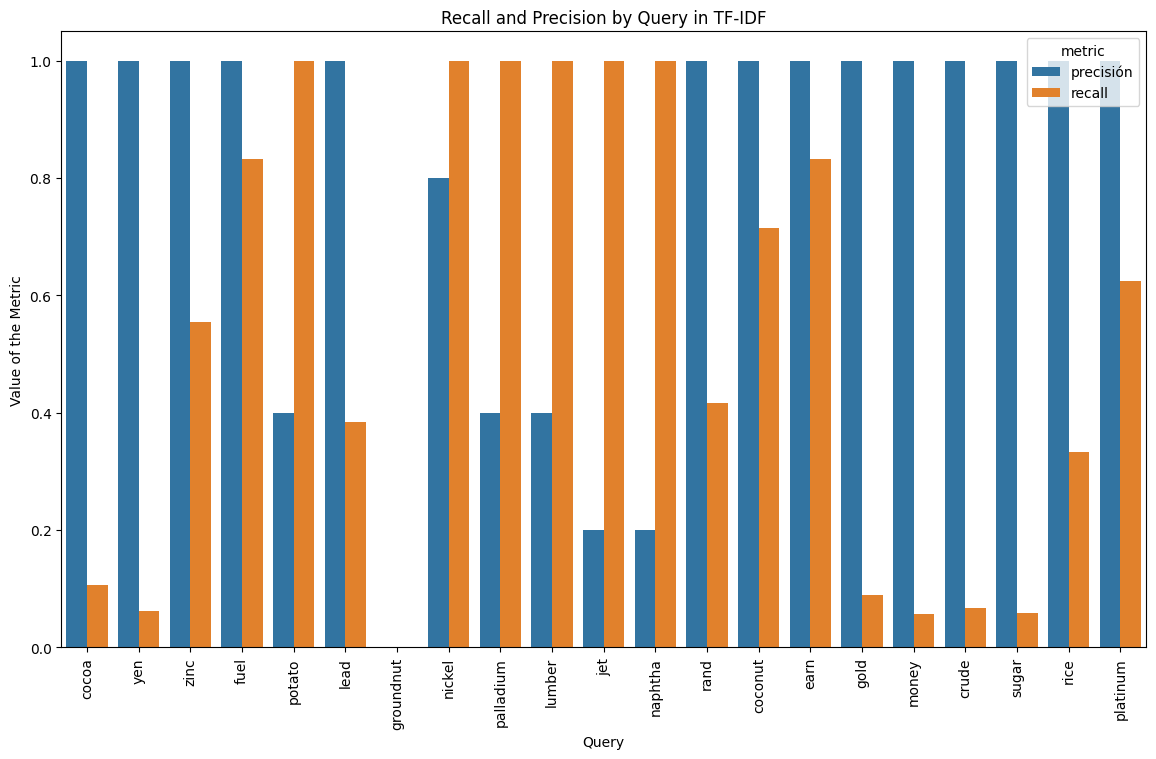

In [ ]:
# DataFrame para tener las métricas
df_melted_tfidf = df_metricas.melt(id_vars='query', value_vars=['precisión', 'recall'], var_name='metric', value_name='value')

# Crear la figura
plt.figure(figsize=(14, 8))

# Crear el gráfico de barras
sns.barplot(x='query', y='value', hue='metric', data=df_melted_tfidf)

# Configurar el gráfico
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para que se vean mejor
plt.title('Recall and Precision by Query in TF-IDF')  # Título del gráfico
plt.xlabel('Query')  # Etiqueta del eje X
plt.ylabel('Value of the Metric')  # Etiqueta del eje Y

# Mostrar el gráfico
plt.show()

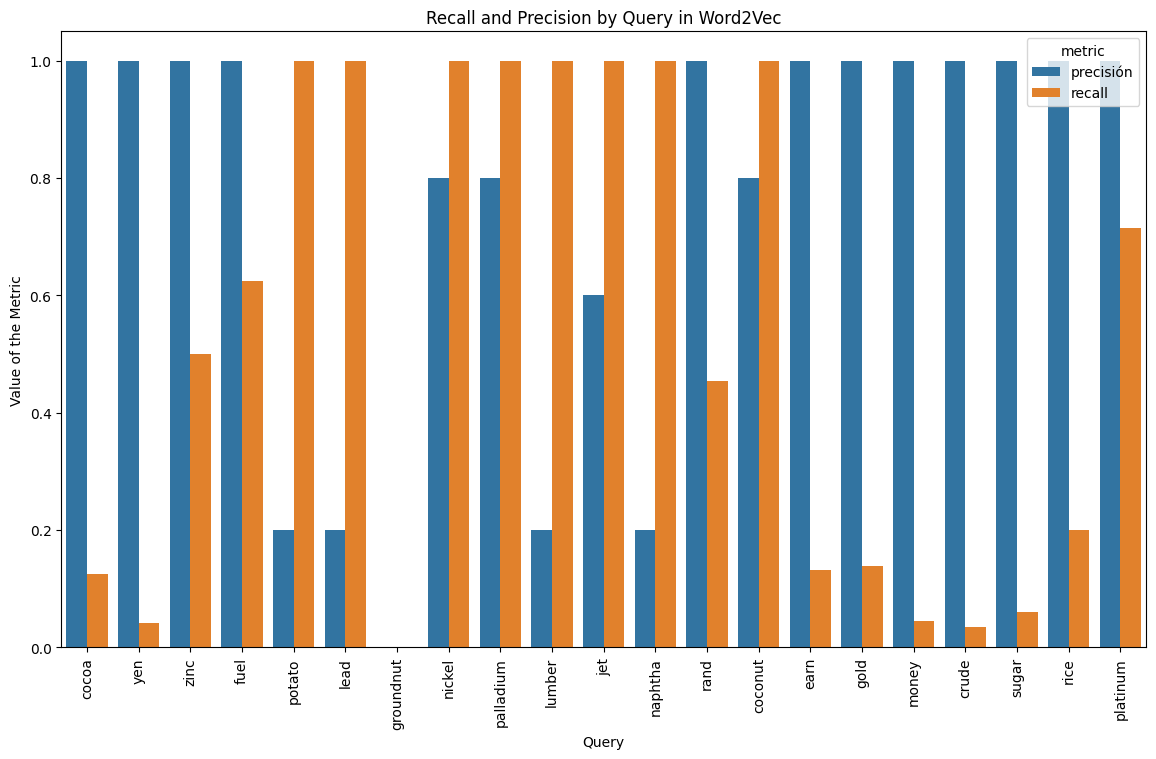

In [46]:
# DataFrame para tener las métricas
df_melted_w2v = df_metricas_w2v.melt(id_vars='query', value_vars=['precisión', 'recall'], var_name='metric', value_name='value')

# Crear la figura
plt.figure(figsize=(14, 8))

# Crear el gráfico de barras
sns.barplot(x='query', y='value', hue='metric', data=df_melted_w2v)

# Configurar el gráfico
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para que se vean mejor
plt.title('Recall and Precision by Query in Word2Vec')  # Título del gráfico
plt.xlabel('Query')  # Etiqueta del eje X
plt.ylabel('Value of the Metric')  # Etiqueta del eje Y

# Mostrar el gráfico
plt.show()

- **TF-IDF:**  es un método sencillo y eficiente para recuperar documentos relevantes basados en la frecuencia de palabras. Ofrece alta precisión, ya que identifica rápidamente los documentos que contienen los términos exactos de la consulta. Sin embargo, su recall y F1-score son más bajos, especialmente cuando las consultas son generales, ya que solo considera la frecuencia de términos sin tener en cuenta el contexto o sinónimos.

- **Word2Vec:**  captura el significado contextual de las palabras y sus relaciones, lo que mejora el recall y F1-score al identificar documentos relevantes incluso si contienen sinónimos o términos semánticamente similares. Sin embargo, su precisión es menor en comparación con TF-IDF, ya que puede recuperar documentos irrelevantes debido a la interpretación contextual más amplia.

**¿Cuál es mejor?**
Si buscamos precisión y resultados muy específicos, TF-IDF es mejor. Si nuestra prioridad es recuperar más documentos relevantes y tener en cuenta contextos o sinónimos, Word2Vec es superior. Sin embargo, Word2Vec puede tener una precisión más baja en algunos casos. La elección depende de si preferimos precisión exacta o un mayor alcance en los resultados.